# Atividade 5

Planejamento de Sistemas Elétricos - PPEE

Aluna: Adriana Mendonça

A partir do trabalho do Alexandre Soares Altgott

In [ ]:
!pip install PySDDP

In [ ]:
from google.colab import drive, files
import os

#Montar o Google Drive no Colab com o nome gdrive

drive.mount('/content/gdrive')

# O comando abaixo mostra qual diretório você está trabalhando momento.
print( os.getcwd() )

Caminho_do_Arquivo = 'gdrive/My Drive/NewaveJuly2023/'
# O comando mostra o que está presente dentro da minha pasta GIF no meu drive, que está dentro do meu drive e em Doutorado. Mudar para o diretório que vocês criaram.
print( os.listdir(Caminho_do_Arquivo) )

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content
['FORMAT.TMP', 'ELNINO.DAT', 'PENALID.DAT', 'GHMIN.DAT', 'NewaveMsgPortug.txt', 'ITAIPU.DAT', 'MENSAG.TMP', 'CLAST.DAT', 'ADTERM.DAT', 'GTMINPAT.DAT', 'CVAR.DAT', 'LOSS.DAT', 'ARQUIVOS.DAT', 'AGRINT.DAT', 'ENSOAUX.DAT', 'CDEFVAR.DAT', 'EXPH.DAT', 'C_ADIC.DAT', 'CASO.DAT', 'MANUTT.DAT', 'CONFT.DAT', 'CURVA.DAT', 'MODIF.DAT', 'DSVAGUA.DAT', 'BID.DAT', 'CONFHD.DAT', 'HIDR.DAT', 'EXPT.DAT', 'SISTEMA.DAT', 'TERM.DAT', 'SHIST.DAT', 'VAZPAST.DAT', 'PATAMAR.DAT', 'GTMIN_CCEE_072023.xlsx', 'VAZOES.DAT', 'REE.DAT', 'selcor.dat', 'RE.DAT', 'POSTOS.DAT', 'DGER.DAT', 'tecno.dat']


In [ ]:
from PySDDP.Pen import Newave

PMOSET2023 = Newave(Caminho_do_Arquivo)

OK! Leitura do CASO.DAT realizada com sucesso.
OK! Leitura do ARQUIVOS.DAT realizada com sucesso.
OK! Leitura do DGER.DAT realizada com sucesso.
OK! Leitura do HIDR.DAT realizada com sucesso.
OK! Leitura do VAZOES.DAT realizada com sucesso.
OK! Leitura do MODIF.DAT realizada com sucesso. ( 99 Usinas Hidraulicas Modificadas )
OK! Leitura do EXPH.DAT realizada com sucesso. ( 2 Usinas Hidraulicas Expandidas )
OK! Leitura do CONFHD.DAT realizada com sucesso.
OK! Leitura do REE.DAT realizada com sucesso. ( 12 Reservatórios Equivalentes de Energia Foram Lidos )
OK! Leitura do SISTEMA.DAT realizada com sucesso.


In [ ]:
Usina = PMOSET2023.confhd.get('Furnas')

## Modelo de Otimização para o Problema Analisado

Para o caso exemplo do mês de agosto a ser estimado a vazão

$Min \hspace{0.5cm} \varepsilon_{ago,1931}^2 + \varepsilon_{ago,1932}^2  + ... + \varepsilon_{ago,2020}^2  + \varepsilon_{ago,2021}^2  $

Sujeito a:

$Z_{ago,1932} = \phi_1 \cdot Z_{jul,1932} + \phi_2 \cdot Z_{jun,1932} + ... +  \phi_n \cdot Z_{n,1932}  + \varepsilon_{mar,1932}^2  $

$Z_{ago,1933} = \phi_1 \cdot Z_{jul,1933} + \phi_2 \cdot Z_{jun,1933} + ... +  \phi_n \cdot Z_{n,1933}  + \varepsilon_{mar,1933}^2  $

.

.

.

$Z_{ago,2021} = \phi_1 \cdot Z_{jul,2021} + \phi_2 \cdot Z_{jun,2021} + ... +  \phi_n \cdot Z_{n,2021}  + \varepsilon_{mar,2021}^2  $

## Função do Modelo Auto-Regressivo

In [ ]:
from cvxopt import matrix, solvers
import numpy as np


def Series_Sinteticas(Usina, AnoAnalisado, N_meses, Mes_analisado,imprime = False):
    """
    Função que calcula a série sintética de vazões de uma usina
    """

    # Retira o ultimo e o primeiro ano e considera que a contagem começa em zero
    N_anos = len(Usina['vazoes']) - 3

    AnoAnalisado = AnoAnalisado - 2023 + N_anos + 2

    if Mes_analisado - N_meses >= 0:

        recorte = Usina['vazoes'][1:N_anos+1,(Mes_analisado-N_meses):Mes_analisado]

    else:

        recorteAnoAtual = Usina['vazoes'][1:N_anos+1,0:Mes_analisado]

        recorteAnoAnt = Usina['vazoes'][0:N_anos,(Mes_analisado-N_meses):]

        recorte = np.hstack((recorteAnoAnt,recorteAnoAtual))


    identidade = np.eye(N_anos)

    Aeq1 = np.concatenate((recorte, identidade), axis = 1)
    res1 = np.zeros((1,N_meses))
    res2 = (1/N_anos)*np.ones((1,N_anos))
    res = np.concatenate((res1,res2), axis = 1)
    Aeq = np.concatenate((Aeq1,res))
    Aeq = Aeq.astype('float')
    Aeq = matrix(Aeq)

    Beq1 = Usina['vazoes'][1:N_anos+1,Mes_analisado]
    Beq = np.concatenate((Beq1,[0]))
    Beq = Beq.astype('float')
    Beq = matrix(Beq)

    q = matrix(np.zeros(N_anos+N_meses))
    P = 2*np.eye(N_anos+N_meses)
    for i in range(0,N_meses):
        P[i][i] = 0
    P = matrix(P)

    A = np.vstack((-1*np.eye(N_anos+N_meses), np.eye(N_anos+N_meses)))
    A = A.astype('float')
    A = matrix(A)
    B = 99999*np.ones(((N_anos+N_meses)*2,1))

    B = B.astype('float')
    B = matrix(B)


    solvers.options['show_progress'] = False
    abstol = 1e-9
    reltol = 1e-9
    sol = solvers.qp(P, q, A, B, Aeq, Beq, abstol=abstol, reltol=reltol)

    fob = sum(sol['x'][N_meses:])

    if Mes_analisado - N_meses >= 0:

        soma = 0

        for i, v in enumerate(Usina['vazoes'][AnoAnalisado,(Mes_analisado-N_meses):Mes_analisado]):

            soma += v*sol['x'][i]

    else:

        soma = 0

        for i, v in enumerate(Usina['vazoes'][AnoAnalisado,0:Mes_analisado]):

            soma += v*sol['x'][i+N_meses-Mes_analisado]

        for i, v in enumerate(Usina['vazoes'][AnoAnalisado-1,(Mes_analisado-N_meses):]):

            soma += v*sol['x'][i]

    if imprime:

        print(f'Vazão estimada para o mês {Mes_analisado}: {soma} hm^3')

    return [fob,soma,sol['x']]


## Programa Principal

A vazão estimada para o mês 12, considerando os 3 últimos meses para o cálculo, é de: 539.1438976067676 m³/s


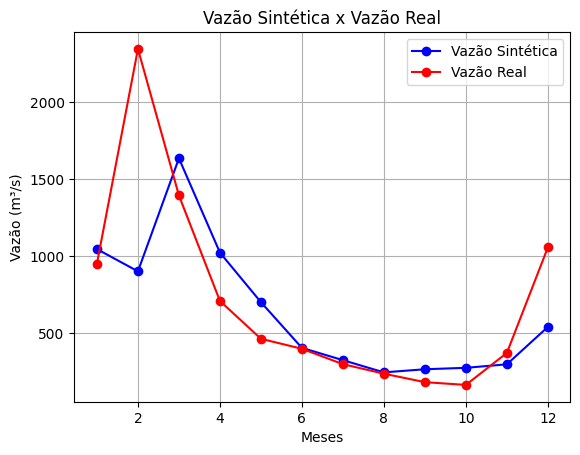

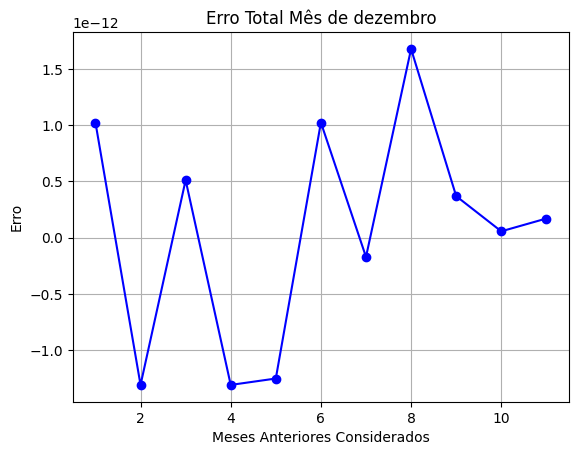

In [ ]:
from cvxopt import matrix, solvers
from matplotlib import pyplot as plt
Ordem = np.zeros((12,11))

# Ano a ser analisado
AnoAnalisado = 2020

# Numero de meses anteriores a serem considerados
N_meses = 3

# Retira o ultimo e o primeiro ano e considera que a contagem começa em zero
N_anos = len(Usina['vazoes']) - 3

# Numero do mes considerando janeiro zero
Mes_analisado = 11

# Excluir anos mais recentes caso queira
# Usina['vazoes'] = Usina['vazoes'][:-2]


print(f'A vazão estimada para o mês {Mes_analisado + 1}, considerando os {N_meses} últimos meses para o cálculo, é de: {Series_Sinteticas(Usina, AnoAnalisado, N_meses, Mes_analisado)[1]} m³/s')

resultado = []
fob = []

for i in range(0,12):

    resposta = Series_Sinteticas(Usina, AnoAnalisado, N_meses, i)
    resultado.append(resposta[1])


for i in range(1,12):

    resposta = Series_Sinteticas(Usina, AnoAnalisado, i, Mes_analisado)
    fob.append(resposta[0])

for vari in range(0,12):  # mes analisado
  for i in range(1,12):   # ordem
    res = Series_Sinteticas(Usina, AnoAnalisado, i, vari)
    Ordem[vari,i-1] = res[0]

# Converte o ano para o indice da lista
AnoAnalisado = AnoAnalisado - 2023 + N_anos + 2


plt.figure()
plt.title("Vazão Sintética x Vazão Real")
plt.xlabel("Meses")
plt.ylabel("Vazão (m³/s)")
plt.plot(list(range(1,13)),resultado,marker="o",color="blue",label="Vazão Sintética")
plt.plot(list(range(1,13)),Usina['vazoes'][AnoAnalisado],marker="o",color="red",label="Vazão Real")
plt.legend()
plt.grid()


mes = ['janeiro', 'fevereiro', 'março', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro', 'novembro', 'dezembro']
plt.figure()
plt.title('Erro Total Mês de ' + mes[Mes_analisado])
plt.xlabel("Meses Anteriores Considerados")
plt.ylabel("Erro")
plt.plot(list(range(1,12)),fob,marker="o",color="blue")
plt.grid()



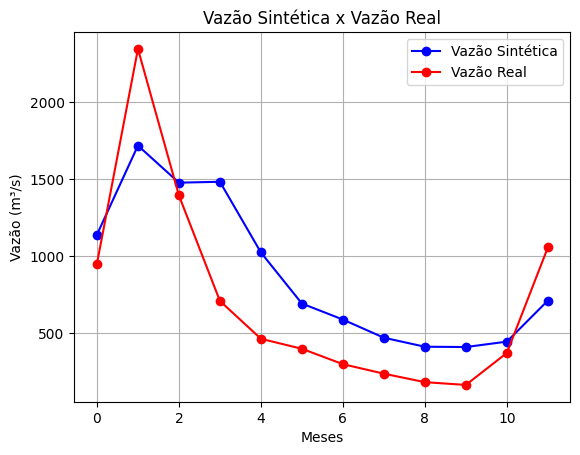

In [ ]:
import random

n_meses = 12
n_aberturas = 70
n_sequencias = 500
vazoes = Usina['vazoes'][0:92]
sorteio_vazoes = np.zeros((n_aberturas,n_meses))
for num1 in range(n_aberturas):
  for num2 in range(n_meses):
    vaz = vazoes[:,Mes_analisado-num2-1]
    sorteio_vazoes[num1,num2] = random.choice(vaz)
#print(sorteio_vazoes) # mes-1 mes-2 mes-3
vazoes_sequenciais = np.zeros((n_sequencias,n_meses))
for num1 in range(n_sequencias):
  for num2 in range(n_meses):
    vaz = sorteio_vazoes[:,num2]
    vazoes_sequenciais[num1,num2] = random.choice(vaz)
#print(vazoes_sequenciais)

media1 = np.zeros((n_meses,1))
media = np.zeros((n_meses,1))
for num1 in range(n_meses):
  media1[num1,0] = np.mean(vazoes_sequenciais[:,num1])
for num1 in range(n_meses):
  media[n_meses-num1-1,0] = media1[num1,0]

plt.figure()
plt.title("Vazão Sintética x Vazão Real")
plt.xlabel("Meses")
plt.ylabel("Vazão (m³/s)")
plt.plot(media,marker="o",color="blue",label='Vazão Sintética')
plt.plot(Usina['vazoes'][AnoAnalisado],marker="o",color="red",label="Vazão Real")
plt.legend()
plt.grid()

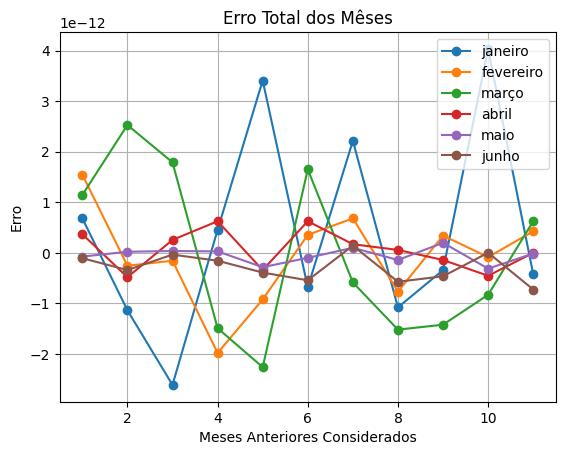

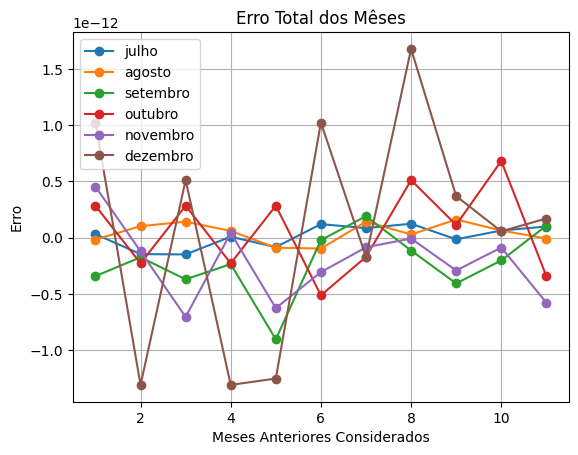

In [ ]:
plt.figure()
plt.title('Erro Total dos Mêses')
plt.xlabel("Meses Anteriores Considerados")
plt.ylabel("Erro")
for num1 in range(0,6):
  plt.plot(list(range(1,12)),Ordem[num1],marker="o",label=mes[num1])
plt.legend()
plt.grid()

plt.figure()
plt.title('Erro Total dos Mêses')
plt.xlabel("Meses Anteriores Considerados")
plt.ylabel("Erro")
for num1 in range(6,12):
  plt.plot(list(range(1,12)),Ordem[num1],marker="o",label=mes[num1])
plt.legend()
plt.grid()

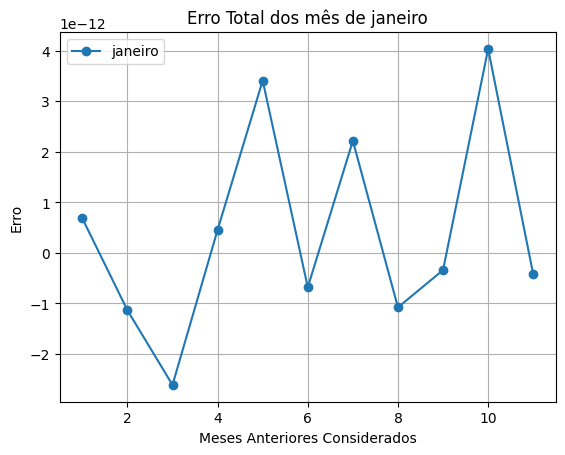

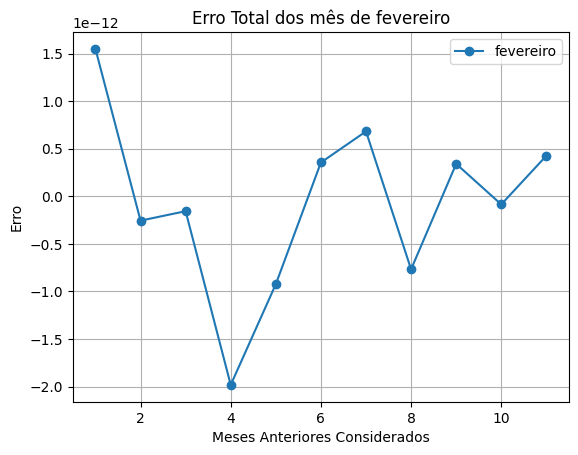

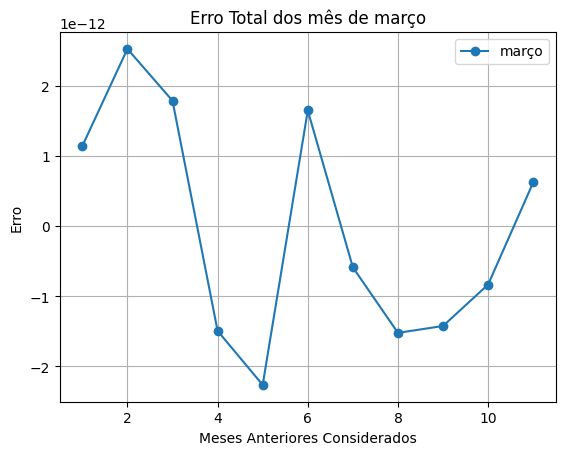

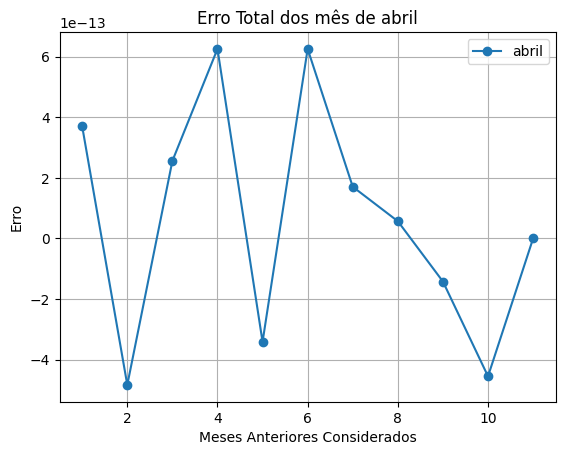

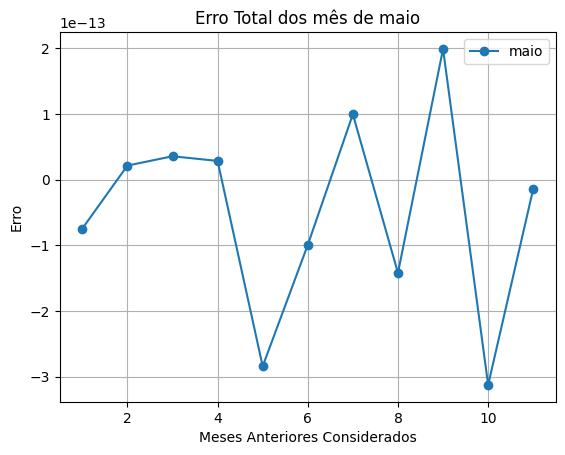

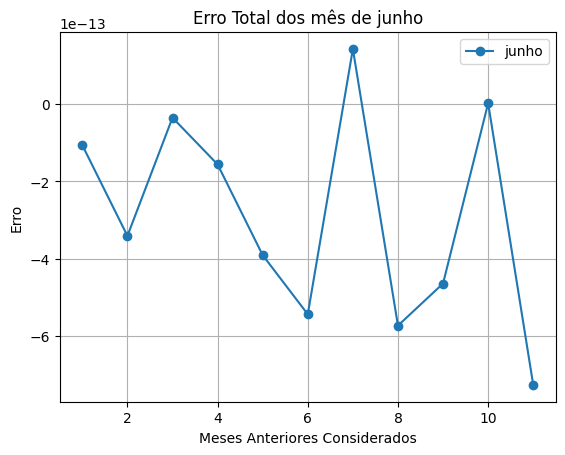

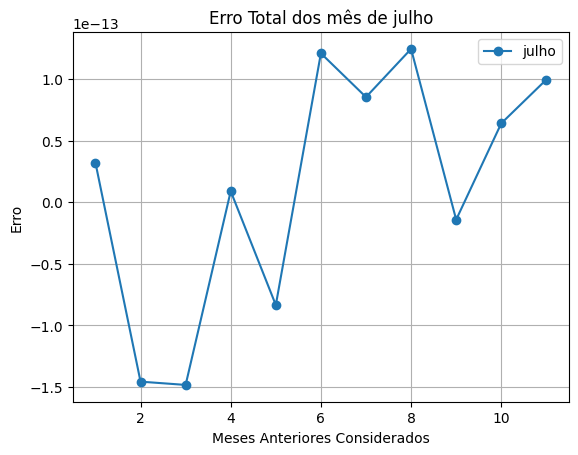

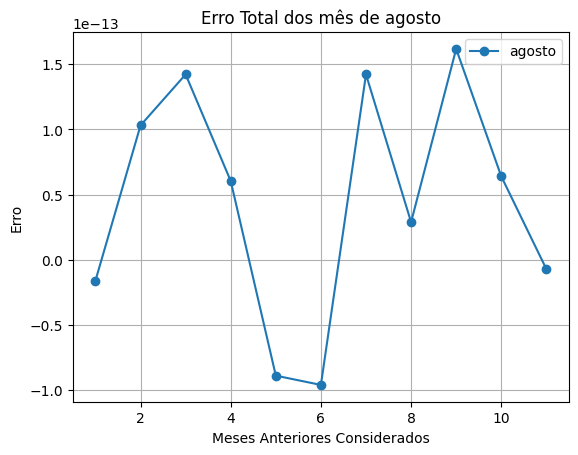

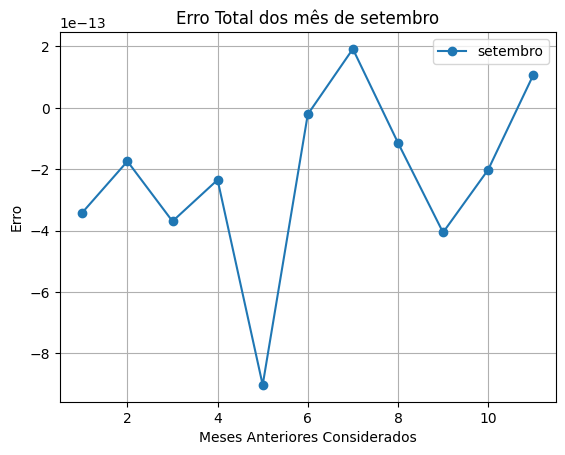

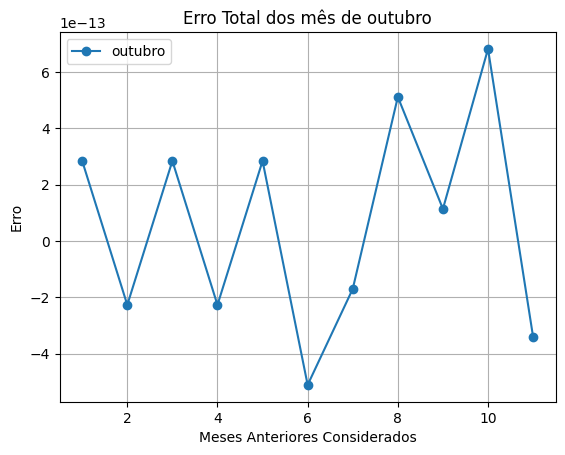

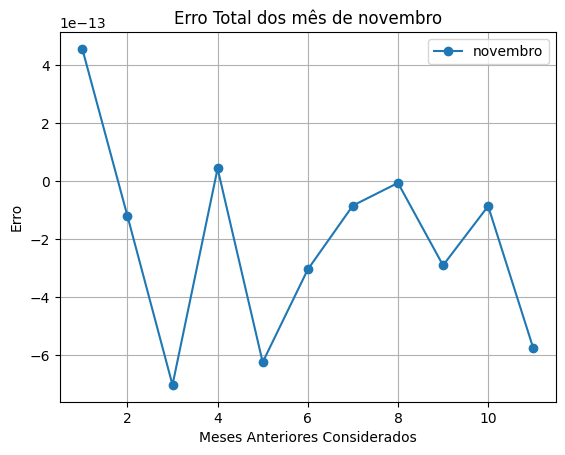

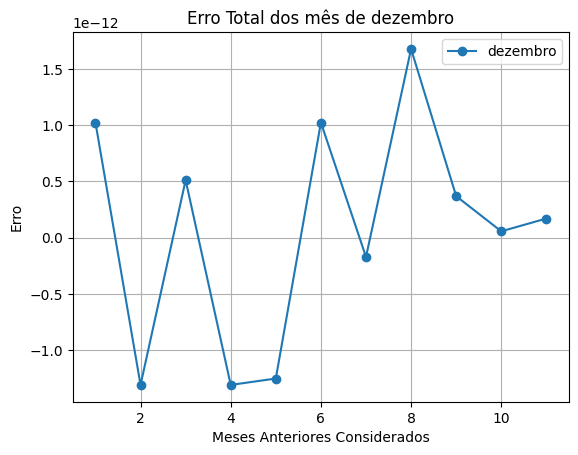

In [ ]:
for num1 in range(0,12):
  plt.figure()
  plt.title('Erro Total dos mês de ' + mes[num1])
  plt.xlabel("Meses Anteriores Considerados")
  plt.ylabel("Erro")
  plt.plot(list(range(1,12)),Ordem[num1],marker="o",label=mes[num1])
  plt.legend()
  plt.grid()

In [ ]:
melhor_ordem = np.zeros((12,1))
Ordem_melhor = np.zeros((12,1))
for num1 in range(0,12):
  mes_analis = np.abs(Ordem[num1])
  menor = np.min(mes_analis)
  for num2 in range(0,11):
    if mes_analis[num2] == menor:
      melhor_ordem[num1] = num2+1
      Ordem_melhor[num1] = menor
for num1 in range(0,12):
  print('Para o mês de', mes[num1], 'a ordem que teve menor erro foi a ordem', int(melhor_ordem[num1][0]))


Para o mês de janeiro a ordem que teve menor erro foi a ordem 9
Para o mês de fevereiro a ordem que teve menor erro foi a ordem 10
Para o mês de março a ordem que teve menor erro foi a ordem 7
Para o mês de abril a ordem que teve menor erro foi a ordem 11
Para o mês de maio a ordem que teve menor erro foi a ordem 11
Para o mês de junho a ordem que teve menor erro foi a ordem 10
Para o mês de julho a ordem que teve menor erro foi a ordem 4
Para o mês de agosto a ordem que teve menor erro foi a ordem 11
Para o mês de setembro a ordem que teve menor erro foi a ordem 6
Para o mês de outubro a ordem que teve menor erro foi a ordem 9
Para o mês de novembro a ordem que teve menor erro foi a ordem 8
Para o mês de dezembro a ordem que teve menor erro foi a ordem 10


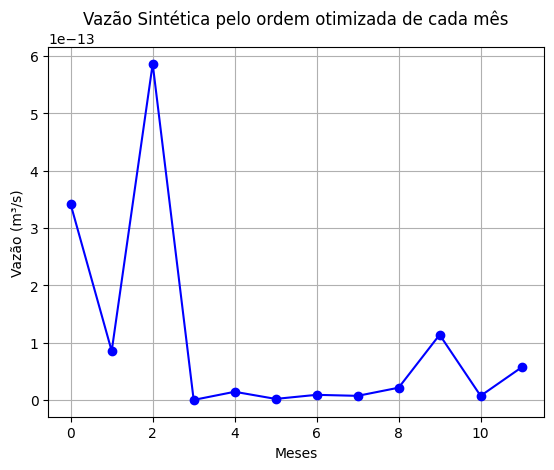

In [ ]:
plt.figure()
plt.title('Vazão Sintética pelo ordem otimizada de cada mês')
plt.xlabel("Meses")
plt.ylabel("Vazão (m³/s)")
plt.plot(Ordem_melhor,marker="o",color="blue")
plt.grid()

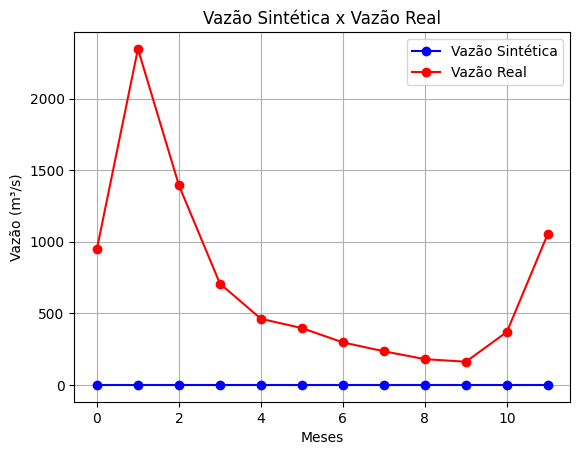

In [ ]:
plt.figure()
plt.title("Vazão Sintética x Vazão Real")
plt.xlabel("Meses")
plt.ylabel("Vazão (m³/s)")
plt.plot(Ordem_melhor,marker="o",color="blue",label='Vazão Sintética')
plt.plot(Usina['vazoes'][AnoAnalisado],marker="o",color="red",label="Vazão Real")
plt.legend()
plt.grid()